In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Input training data
Commented out: original data
For use the datapoint at Q=10L/s and BP=10 is omitted since it seemed erroneous.

In [21]:
import pandas as pd

# Create the dataframe based on the provided data
#data = {
#    "BP": [30, 25, 20, 15, 10, 0, 30, 25, 20, 15, 10, 0, 30, 25, 20, 15, 10, 0],
#    "Q": [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 10, 10, 10, 10, 10, 10, 27, 27, 27, 27, 27, 27],
#    "S": [0.1041, 0.1065, 0.1100, 0.1299, 0.1303, 1.0000, 0.276, 0.278, 0.295, 0.31, 1, 1, 0.506, 0.520, 0.550, 0.560, 0.596, 1.000]
#}

data = {
    "BP": [30, 25, 20, 15, 10, 0, 30, 25, 20, 15, 0, 30, 25, 20, 15, 10, 0],
    "Q": [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 10, 10, 10, 10, 10, 27, 27, 27, 27, 27, 27],
    "S": [0.1041, 0.1065, 0.1100, 0.1299, 0.1303, 1.0000, 0.276, 0.278, 0.295, 0.31, 1, 0.506, 0.520, 0.550, 0.560, 0.596, 1.000]
}

df_settings = pd.DataFrame(data)

# Define model

In [67]:
# Define the model function
def model_function(X, b0, b1, c1):
    BP, Q = X
    c = Q * c1
    return np.maximum((1 - c) * np.exp(b0 * BP + b1) + c, 0)

# Initial guesses for the parameters (these should be reasonable guesses based on your knowledge of the data)
initial_guesses = [-3, 5, 0.2]

# Train and test data ensembles

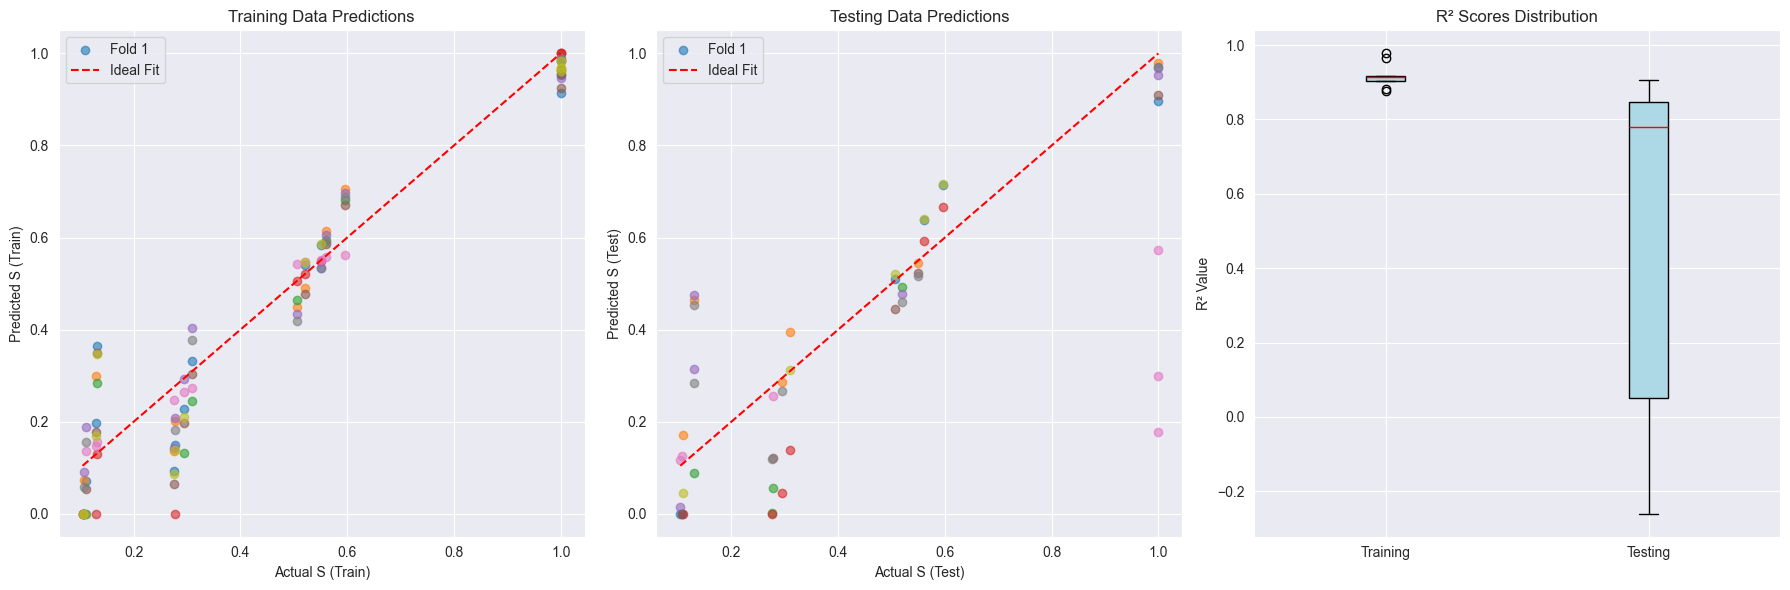

In [68]:
# Prepare for Repeated K-Fold Cross-Validation
rkf = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)
r2_train_scores = []
r2_test_scores = []

# Lists to store parameter values for each fold
b0_values = []
b1_values = []
c1_values = []

# Colors for different folds
colors = ['blue', 'green', 'orange']

# Visualization setup
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the different training/testing splits
for fold, (train_index, test_index) in enumerate(rkf.split(df_settings)):
    # Split the data into training and testing sets
    train_df = df_settings.iloc[train_index].copy()
    test_df = df_settings.iloc[test_index].copy()

    # Standardize the BP and Q columns based on the training set
    scaler = StandardScaler()
    train_df[['BP_standardized', 'Q_standardized']] = scaler.fit_transform(train_df[['BP', 'Q']])
    test_df[['BP_standardized', 'Q_standardized']] = scaler.transform(test_df[['BP', 'Q']])

    # Prepare the standardized input data for training and testing
    X_train_standardized = train_df[['BP_standardized', 'Q_standardized']].values.T
    X_test_standardized = test_df[['BP_standardized', 'Q_standardized']].values.T
    y_train = train_df['S'].values
    y_test = test_df['S'].values

    # Train the model: Fit curve on the training data
    params, covariance = curve_fit(model_function, X_train_standardized, y_train, p0=initial_guesses)
    
    # Store the trained parameters for each fold
    b0_values.append(params[0])
    b1_values.append(params[1])
    c1_values.append(params[2])

    # Apply the model to the training and testing data using the trained parameters
    train_predictions = model_function(X_train_standardized, *params)
    test_predictions = model_function(X_test_standardized, *params)

    # Calculate R² value for training and testing sets
    r2_train = r2_score(y_train, train_predictions)
    r2_test = r2_score(y_test, test_predictions)

    # Store the R² values
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

    # Plotting each fold's predictions
    axes[0].scatter(y_train, train_predictions, alpha=0.6, label=f'Fold {fold + 1}' if fold == 0 else "")
    axes[1].scatter(y_test, test_predictions, alpha=0.6, label=f'Fold {fold + 1}' if fold == 0 else "")

# Add Ideal Fit lines
# For Training
all_train_S = df_settings['S']
axes[0].plot([all_train_S.min(), all_train_S.max()], [all_train_S.min(), all_train_S.max()], color='red', linestyle='--', label='Ideal Fit')

# For Testing
all_test_S = df_settings['S']
axes[1].plot([all_test_S.min(), all_test_S.max()], [all_test_S.min(), all_test_S.max()], color='red', linestyle='--', label='Ideal Fit')

# Set labels and titles for Training Plot
axes[0].set_xlabel('Actual S (Train)')
axes[0].set_ylabel('Predicted S (Train)')
axes[0].set_title('Training Data Predictions')
axes[0].legend()

# Set labels and titles for Testing Plot
axes[1].set_xlabel('Actual S (Test)')
axes[1].set_ylabel('Predicted S (Test)')
axes[1].set_title('Testing Data Predictions')
axes[1].legend()

# R² Boxplots for Training and Testing
axes[2].boxplot([r2_train_scores, r2_test_scores], labels=['Training', 'Testing'], patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red'))
axes[2].set_title('R² Scores Distribution')
axes[2].set_ylabel('R² Value')

plt.tight_layout()
plt.show()

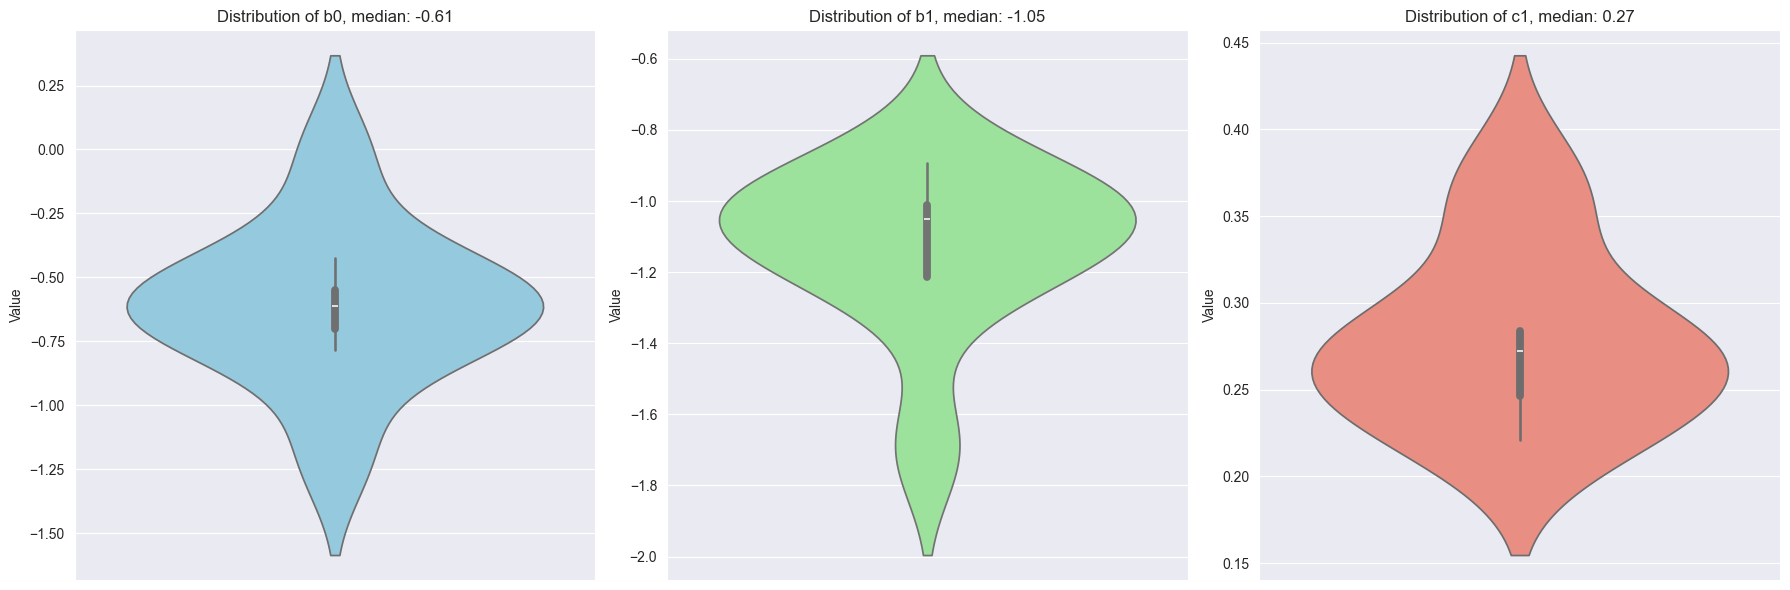

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for seaborn
# Convert to DataFrame for easier plotting with seaborn
df = pd.DataFrame([b0_values, b1_values, c1_values], index=["b0", "b1", "c1"]).T

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each parameter's distribution
sns.violinplot(data=df['b0'], ax=axes[0], color="skyblue")
axes[0].set_title(f'Distribution of b0, median: {df["b0"].median():.2f}')
axes[0].set_ylabel('Value')

sns.violinplot(data=df['b1'], ax=axes[1], color="lightgreen")
axes[1].set_title(f'Distribution of b1, median: {df["b1"].median():.2f}')
axes[1].set_ylabel('Value')

sns.violinplot(data=df['c1'], ax=axes[2], color="salmon")
axes[2].set_title(f'Distribution of c1, median: {df["c1"].median():.2f}')
axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()

C:\Users\alber\PycharmProjects\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


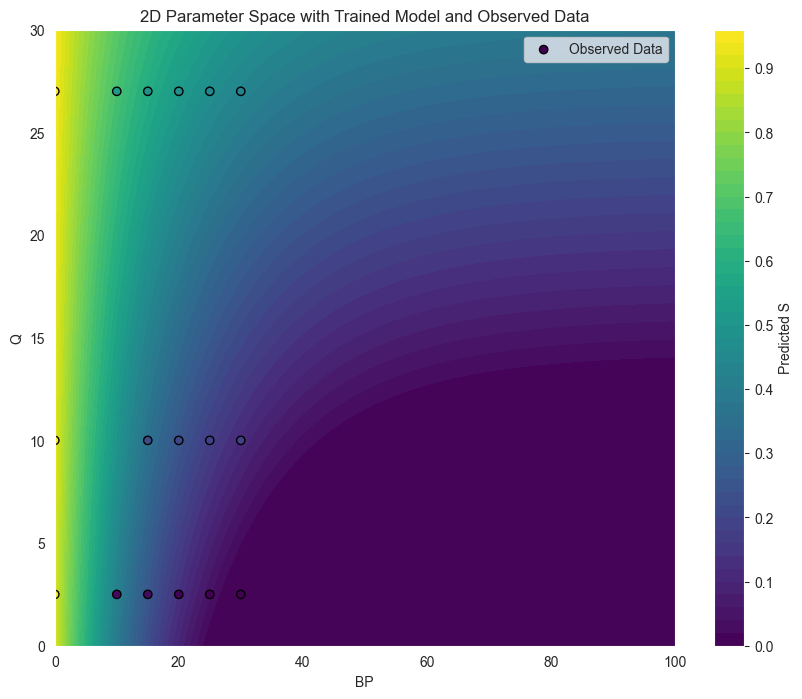

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming df_settings is your DataFrame containing 'BP', 'Q', and 'S' columns

# Define the model function
def model_function(BP, Q, b0, b1, c1):
    c = c1 * Q
    return np.maximum((1 - c) * np.exp(b0 * BP + b1) + c, 0)

# Parameters from the trained model
b0 = -0.55
b1 = -1.02
c1 = 0.24

# Fit the StandardScaler on the original training data
scaler = StandardScaler()
scaler.fit(df_settings[['BP', 'Q']])

# Create the BP and Q meshgrid for the parameter space
BP_values = np.linspace(0, 100, 200)
Q_values = np.linspace(0, 30, 200)
BP_mesh, Q_mesh = np.meshgrid(BP_values, Q_values)

# Flatten the meshgrid and combine for scaling
BP_Q_combined = np.c_[BP_mesh.ravel(), Q_mesh.ravel()]

# Standardize the combined meshgrid inputs
BP_Q_scaled = scaler.transform(BP_Q_combined)

# Reshape the scaled values back into meshgrid format
BP_mesh_scaled = BP_Q_scaled[:, 0].reshape(BP_mesh.shape)
Q_mesh_scaled = BP_Q_scaled[:, 1].reshape(Q_mesh.shape)

# Compute the model predictions over the standardized parameter space
S_mesh = model_function(BP_mesh_scaled, Q_mesh_scaled, b0, b1, c1)

# Plotting the parameter space
plt.figure(figsize=(10, 8))
cp = plt.contourf(BP_mesh, Q_mesh, S_mesh, levels=50, cmap='viridis')
plt.colorbar(cp, label='Predicted S')

# Overlay the observed data as a scatter plot
plt.scatter(df_settings['BP'], df_settings['Q'], c=df_settings['S'], cmap='viridis', edgecolor='black', label='Observed Data')

# Labels and title
plt.xlabel('BP')
plt.ylabel('Q')
plt.title('2D Parameter Space with Trained Model and Observed Data')
plt.legend()
plt.show()

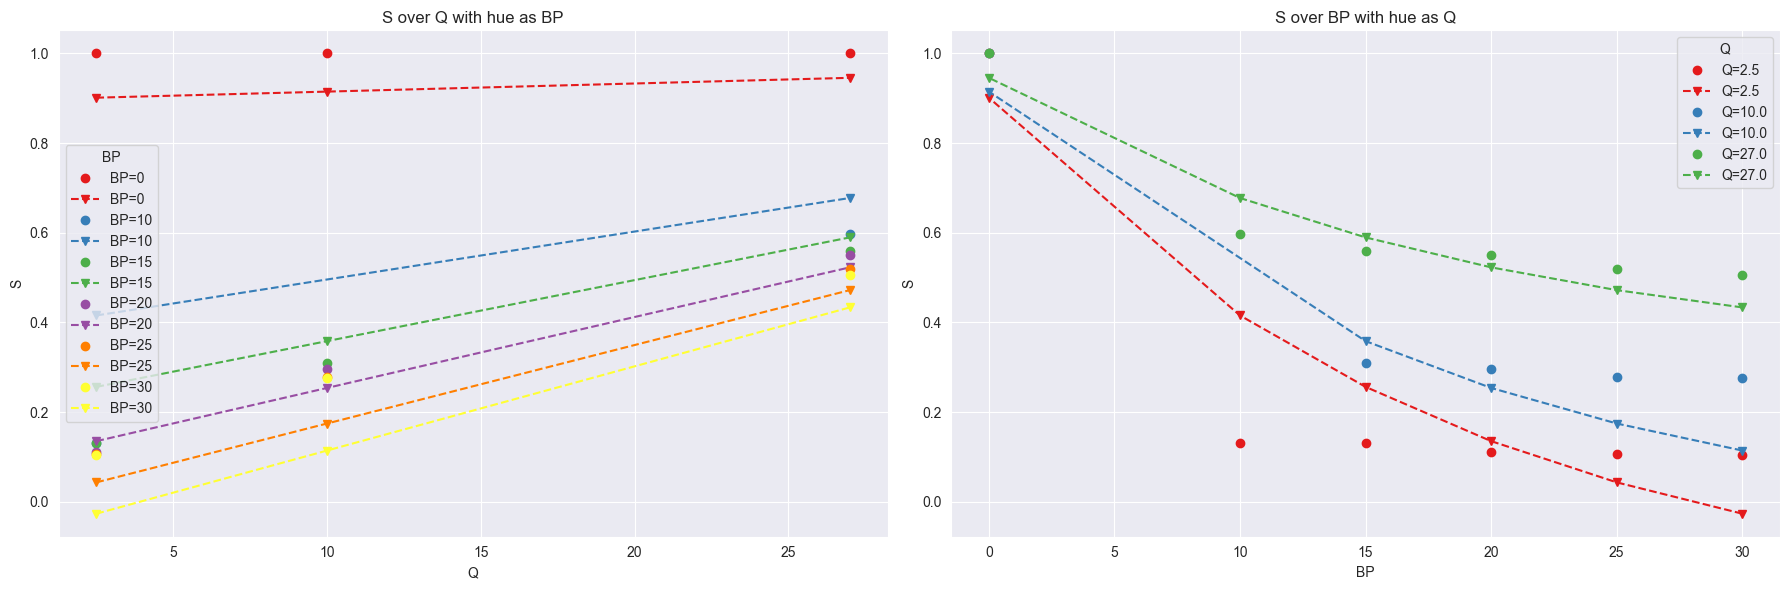

In [71]:
import matplotlib.pyplot as plt

# Define the model function
def model_function(X, b0, b1, c1):
    BP, Q = X
    c = c1 * Q
    return (1 - c) * np.exp(b0 * BP + b1) + c

params = [-0.55, -1.02, 0.24]
df_settings[['BP_standardized', 'Q_standardized']] = scaler.transform(df_settings[['BP', 'Q']])
df_settings["S_pred"] = df_settings[["BP_standardized", "Q_standardized"]].apply(model_function, args=params, axis=1)

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot S over Q with hue as BP
for i, (bp, group) in enumerate(df_settings.groupby('BP')):
    color = plt.get_cmap("Set1")(i)
    axes[0].plot(group['Q'], group['S'], label=f'BP={bp}', color=color, marker="o", ls="")
    axes[0].plot(group['Q'], group['S_pred'], label=f'BP={bp}', color=color, linestyle="dashed", marker="v")
    
axes[0].set_title('S over Q with hue as BP')
axes[0].set_xlabel('Q')
axes[0].set_ylabel('S')
axes[0].legend(title='BP')

# Plot S over BP with hue as Q
for i, (q, group) in enumerate(df_settings.groupby('Q')):
    color = plt.get_cmap("Set1")(i)
    axes[1].plot(group['BP'], group['S'], label=f'Q={q}', color=color, marker="o", ls="")
    axes[1].plot(group['BP'], group['S_pred'], label=f'Q={q}', color=color, linestyle="dashed", marker="v")
axes[1].set_title('S over BP with hue as Q')
axes[1].set_xlabel('BP')
axes[1].set_ylabel('S')
axes[1].legend(title='Q')

# Adjust layout
plt.tight_layout()
plt.show()

help(cmap)